# Chargement des données et Statistiques

In [6]:
import json
import pandas as pd
import random
from collections import Counter
import matplotlib.pyplot as plt

#  1. FONCTIONS DE CHARGEMENT

def load_jsonl_to_dict(filepath, key_field='_id'):
    data_dict = {}
    print(f"Chargement de {filepath}...")
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            doc = json.loads(line)
            data_dict[doc[key_field]] = doc
    print(f"-> {len(data_dict)} documents chargés.")
    return data_dict

#  2. EXÉCUTION DU CHARGEMENT

CORPUS_PATH = 'corpus.jsonl'
QUERIES_PATH = 'queries.jsonl'
VALID_PATH = 'valid.tsv'


# On utilise des dictionnaires pour accéder instantanément à un article via son ID
corpus = load_jsonl_to_dict(CORPUS_PATH)
queries = load_jsonl_to_dict(QUERIES_PATH)

valid_df = pd.read_csv(VALID_PATH, sep='\t')
print(f"-> {len(valid_df)} paires chargées dans valid.tsv")

# 3. STATISTIQUES

print("\n STATISTIQUES ")
num_queries_in_valid = valid_df['query-id'].nunique()
print(f"Nombre total d'articles dans le corpus : {len(corpus)}")
print(f"Nombre de requêtes uniques dans valid.tsv : {num_queries_in_valid}")
print(f"Nombre total de paires (lignes dans valid) : {len(valid_df)}")

# la distribution des 0 et des 1
distribution = valid_df['score'].value_counts(normalize=True)
print("\nProportions globales :")
print(f"Exemples Positifs (Score 1) : {distribution.get(1, 0)*100:.2f}%")
print(f"Exemples Négatifs (Score 0) : {distribution.get(0, 0)*100:.2f}%")



Chargement de corpus.jsonl...
-> 25657 documents chargés.
Chargement de queries.jsonl...
-> 1000 documents chargés.
-> 20950 paires chargées dans valid.tsv

 STATISTIQUES 
Nombre total d'articles dans le corpus : 25657
Nombre de requêtes uniques dans valid.tsv : 700
Nombre total de paires (lignes dans valid) : 20950

Proportions globales :
Exemples Positifs (Score 1) : 16.47%
Exemples Négatifs (Score 0) : 83.53%


# Approche Creuse

## BOW


 BAG OF WORDS 
Construction de la matrice Documents-Termes...
Taille de la matrice : (25657, 1000)

Exemple de 10 mots du vocabulaire :
['binary' 'biomedical' 'bitcoin' 'blind' 'block' 'blockchain' 'blood'
 'body' 'boost' 'boosting']

Contenu du premier document (Mots non nuls) :
 - Mot 'hybrid' : 1 fois
 - Mot 'genetic' : 1 fois
 - Mot 'algorithm' : 1 fois
 - Mot 'particle' : 1 fois
 - Mot 'swarm' : 1 fois
 - Mot 'optimization' : 1 fois
 - Mot 'recurrent' : 1 fois
 - Mot 'network' : 1 fois
 - Mot 'design' : 1 fois

Calcul de la distribution des mots...


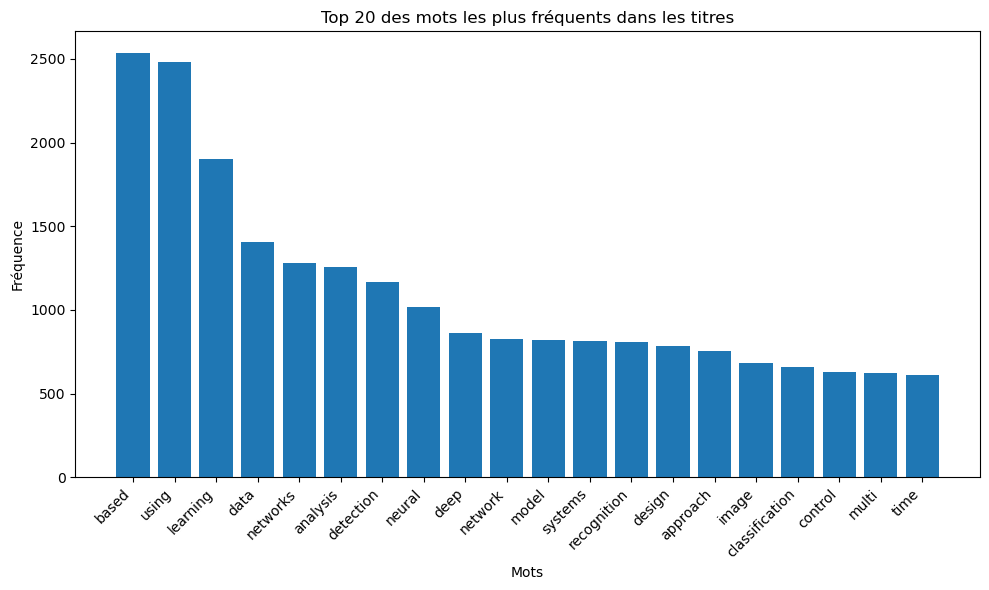

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

print("\n BAG OF WORDS ")

# 1. Préparation des données textuelles
# Pour simplifier au premier, on ne prend que les titres du corpus
# on fait une liste : on doit s'assurer que l'ordre est conservé
corpus_ids = list(corpus.keys())
corpus_titles = [corpus[doc_id].get('title', '') for doc_id in corpus_ids]

# 2. Encodage avec CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=1000)

print("Construction de la matrice Documents-Termes...")
X = vectorizer.fit_transform(corpus_titles)

print(f"Taille de la matrice : {X.shape}")
# (Nombre documents, Taille vocabulaire)

# 3. Affichage des features (mots)
vocab = vectorizer.get_feature_names_out()
print("\nExemple de 10 mots du vocabulaire :")
print(vocab[100:110])

# 4. Affichage d'un vecteur
print("\nContenu du premier document (Mots non nuls) :")
doc0_vector = X[0]
# On récupère les indices où ce n'est pas zéro
non_zero_indices = doc0_vector.nonzero()[1]
for idx in non_zero_indices:
    print(f" - Mot '{vocab[idx]}' : {doc0_vector[0, idx]} fois")

# 5. Histogramme des mots les plus fréquents
print("\nCalcul de la distribution des mots...")
# Somme sur les colonnes (axis=0) pour avoir la fréquence totale de chaque mot
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# Affichage des 20 premiers
top_words = words_freq[:20]
words = [w[0] for w in top_words]
counts = [w[1] for w in top_words]

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 des mots les plus fréquents dans les titres")
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

## Comparaison et Moteur de Recherche (BoW)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

print("\n MOTEUR DE RECHERCHE CLASSIQUE (COSINUS) ")

#  TEST SIMPLE ENTRE DEUX DOCUMENTS
# Prenons deux documents au hasard dans la matrice X
idx_1 = 0 # Premier article du corpus
idx_2 = 1 # Deuxième article

# Calcul de la similarité
score = cosine_similarity(X[idx_1], X[idx_2])[0][0]

print(f"Test de similarité entre doc {idx_1} et doc {idx_2} :")
print(f" - Titre 1 : {corpus_titles[idx_1]}")
print(f" - Titre 2 : {corpus_titles[idx_2]}")
print(f" - Score Cosinus : {score:.4f}")



#  CRÉATION DE LA FONCTION MOTEUR DE RECHERCHE

def moteur_de_recherche_bow(query_text, vectorizer, X_matrix, titles_list, top_k=5):


    # 1 : Vectoriser la requête
    # Remarque : On doit utiliser le vocabulaire DÉJÀ APPRIS sur le corpus.
    query_vec = vectorizer.transform([query_text])

    #  2 : Calculer les scores
    similarities = cosine_similarity(query_vec, X_matrix).flatten()

    #  3 : Trier les résultats
    sorted_indices = similarities.argsort()[::-1]

    # On prend les top_k premiers
    top_indices = sorted_indices[:top_k]

    print(f"\nRésultats pour la requête : '{query_text}'")
    print("-" * 50)

    results = []
    for rank, idx in enumerate(top_indices):
        score = similarities[idx]
        title = titles_list[idx]
        print(f"Rang {rank+1} | Score: {score:.4f} | {title}")
        results.append((idx, score))

    return results




 MOTEUR DE RECHERCHE CLASSIQUE (COSINUS) 
Test de similarité entre doc 0 et doc 1 :
 - Titre 1 : A hybrid of genetic algorithm and particle swarm optimization for recurrent network design
 - Titre 2 : A Hybrid EP and SQP for Dynamic Economic Dispatch with Nonsmooth Fuel Cost Function
 - Score Cosinus : 0.1667


###  TF-IDF


       APPROCHE 2 : TF-IDF       
Construction de la matrice TF-IDF...
Taille de la matrice : (25657, 1000)

Calcul de la distribution des poids...


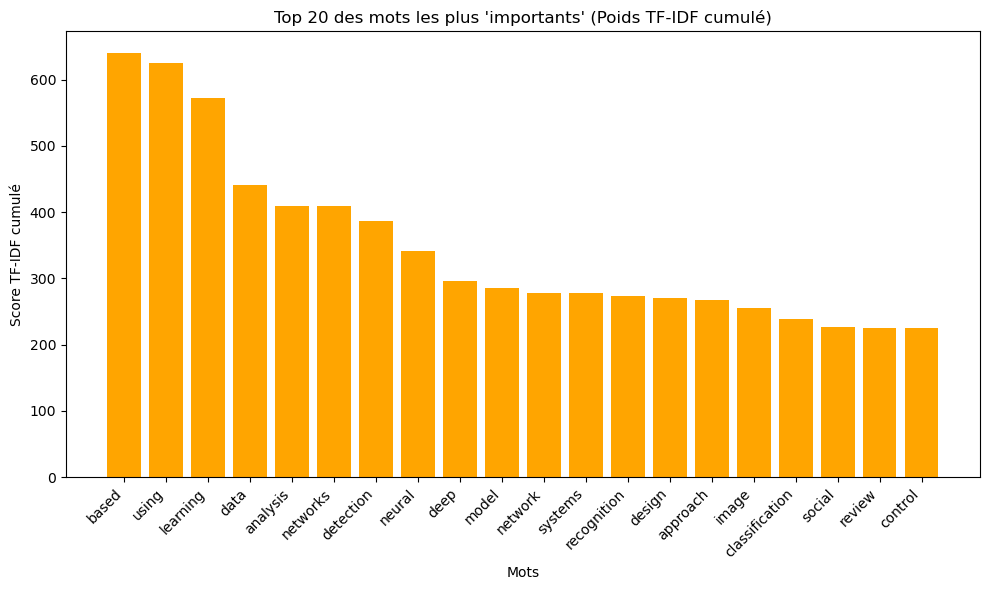


--- COMPARAISON MOTEUR (TF-IDF) ---

Résultats pour la requête : 'Analysis of Deep Convolutional Neural Network'
--------------------------------------------------
Rang 1 | Score: 0.8259 | Analysis of Deep Convolutional Neural Network Architectures
Rang 2 | Score: 0.8064 | Clickbait Convolutional Neural Network
Rang 3 | Score: 0.7797 | Classification of teeth in cone-beam CT using deep convolutional neural network
Rang 4 | Score: 0.7494 | Deep Neural Network Capacity
Rang 5 | Score: 0.7211 | Deep Convolutional Neural Networks [Lecture Notes]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

print("\n" + "="*40)
print("       APPROCHE 2 : TF-IDF       ")
print("="*40)

# 1. Encodage avec TfidfVectorizer
# On garde les mêmes paramètres que BoW pour une comparaison juste
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

print("Construction de la matrice TF-IDF...")
X_tfidf = tfidf_vectorizer.fit_transform(corpus_titles)

print(f"Taille de la matrice : {X_tfidf.shape}")


# 2. Histogramme des poids TF-IDF
print("\nCalcul de la distribution des poids...")


sum_tfidf = X_tfidf.sum(axis=0)

# On récupère les mots et leurs scores
words_scores = [(word, sum_tfidf[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
# Tri décroissant
words_scores = sorted(words_scores, key = lambda x: x[1], reverse=True)

# Préparation du graphique (Top 20)
top_words_tfidf = words_scores[:20]
words_t = [w[0] for w in top_words_tfidf]
scores_t = [w[1] for w in top_words_tfidf]

plt.figure(figsize=(10, 6))
plt.bar(words_t, scores_t, color='orange') # Orange pour différencier du BoW
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 des mots les plus 'importants' (Poids TF-IDF cumulé)")
plt.xlabel("Mots")
plt.ylabel("Score TF-IDF cumulé")
plt.tight_layout()
plt.show()


# 3. Test du Moteur de Recherche (Même exemple que BoW)
print("\n COMPARAISON MOTEUR (TF-IDF) ")

if 'sample_query_id' in locals():
    query_obj = queries.get(sample_query_id)
    real_query_text = query_obj.get('title') or query_obj.get('text') or ""
else:
    real_query_text = "Analysis of Deep Convolutional Neural Network"

if real_query_text:
    moteur_de_recherche_bow(real_query_text, tfidf_vectorizer, X_tfidf, corpus_titles)

In [ ]:
print("\n TEST MOTEUR (BAG OF WORDS) ")

if 'sample_query_id' in locals() and sample_query_id in queries:
    query_obj = queries.get(sample_query_id)
    real_query_text = query_obj.get('title') or query_obj.get('text') or ""
else:
    # Cas de secours (une requête "en dur" pour tester)
    real_query_text = "Analysis of Deep Convolutional Neural Network"

if real_query_text:
    print(f"Requête testée : {real_query_text[:80]}...")
    # On appelle la fonction avec les variables du Bag-of-Words (vectorizer et X)
    moteur_de_recherche_bow(real_query_text, vectorizer, X, corpus_titles)


 TEST MOTEUR (BAG OF WORDS) 
Requête testée : Analysis of Deep Convolutional Neural Network...

Résultats pour la requête : 'Analysis of Deep Convolutional Neural Network'
--------------------------------------------------
Rang 1 | Score: 0.9129 | Analysis of Deep Convolutional Neural Network Architectures
Rang 2 | Score: 0.7746 | Deep Neural Network Capacity
Rang 3 | Score: 0.7746 | Clickbait Convolutional Neural Network
Rang 4 | Score: 0.7442 | Stacking-based deep neural network: Deep analytic network on convolutional spectral histogram features
Rang 5 | Score: 0.7303 | PhaseNet: A Deep Convolutional Neural Network for Two-Dimensional Phase Unwrapping


# L'approche dense

In [ ]:
!pip install sentence-transformers


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Ecodage dense seulment avec les titres

In [ ]:

from sentence_transformers import SentenceTransformer, util
import torch

print("\n ENCODAGE DENSE (EMBEDDINGS) ")

# 1. Chargement du modèle
print("Chargement du modèle 'all-MiniLM-L6-v2'...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Encodage du Corpus
import os
import numpy as np
import torch

# Nom du fichier pour la version "Titre uniquement"
FILE_TITRES = "embeddings_titres_seuls.npy"

print("\n  ENCODAGE DENSE (TITRES SEULS) AVEC CACHE ")



if os.path.exists(FILE_TITRES):
    print(f" Fichier '{FILE_TITRES}' trouvé sur le disque.")
    loaded_data = np.load(FILE_TITRES)
    corpus_embeddings = torch.from_numpy(loaded_data)
    print("Embeddings chargés !")
else:
    print(f"⚠️ Fichier cache introuvable.")
    print("Lancement de l'encodage sur les TITRES (Patientez...)...")

    # Encodage classique
    corpus_embeddings = model.encode(corpus_titles, convert_to_tensor=True, show_progress_bar=True)

    # Sauvegarde sur le disque pour la prochaine fois
    print("Sauvegarde du fichier cache...")
    np.save(FILE_TITRES, corpus_embeddings.cpu().numpy())
    print(" Sauvegardé !")

print(f"Taille de la matrice : {corpus_embeddings.shape}")


#  NOUVEAU MOTEUR DE RECHERCHE SÉMANTIQUE

def moteur_de_recherche_semantic(query_text, model, corpus_embeddings, titles_list, top_k=5):

    # A. Encodage de la requête
    query_embedding = model.encode(query_text, convert_to_tensor=True)

    # B. Calcul de similarité (Cosinus)
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]

    # C. Tri des résultats
    top_results = torch.topk(cos_scores, k=top_k)

    print(f"\n Résultats SÉMANTIQUES pour : '{query_text}'")
    print("-" * 50)

    for score, idx in zip(top_results[0], top_results[1]):
        print(f"Score: {score:.4f} | {titles_list[idx]}")




--- 4. ENCODAGE DENSE (EMBEDDINGS) ---
Chargement du modèle 'all-MiniLM-L6-v2'...

--- 4. ENCODAGE DENSE (TITRES SEULS) AVEC CACHE ---
✅ Fichier 'embeddings_titres_seuls.npy' trouvé sur le disque.
Chargement immédiat...
-> Embeddings chargés !
Taille de la matrice : torch.Size([25657, 384])


### ÉVALUATION GLOBALE (MÉTRIQUES)

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import numpy as np

print("\n  ÉVALUATION GLOBALE (MÉTRIQUES)")

id_to_index = {doc_id: i for i, doc_id in enumerate(corpus_ids)}

# Listes pour stocker toutes les prédictions et les vraies valeurs
y_true_all = []   # Vrais labels (0 ou 1)
y_scores_all = [] # Nos scores de similarité

grouped = valid_df.groupby('query-id')

print(f"Évaluation sur {len(grouped)} requêtes en cours...")

# Compteurs pour les métriques moyennes (Top 5)
precisions_at_5 = []
recalls_at_5 = []

for query_id, group in grouped:

    # A. Récupérer le texte de la requête
    query_obj = queries.get(query_id)
    if not query_obj: continue # Si l'ID n'existe pas, on passe

    q_text = query_obj.get('title') or query_obj.get('text') or ""
    if not q_text.strip(): continue

    # B. Encoder la requête
    q_emb = model.encode(q_text, convert_to_tensor=True)

    # C. Récupérer les embeddings des CANDIDATS de ce groupe
    candidate_indices = []
    labels = []
    valid_rows = []

    for _, row in group.iterrows():
        c_id = row['corpus-id']
        if c_id in id_to_index:
            idx = id_to_index[c_id]
            candidate_indices.append(idx)
            labels.append(row['score'])
            valid_rows.append(row)

    if not candidate_indices: continue

    # D. Calculer les scores pour ces candidats
    candidate_embeddings = corpus_embeddings[candidate_indices]

    # Calcul similarité (Query vs Candidats)
    scores = util.cos_sim(q_emb, candidate_embeddings)[0].cpu().numpy()

    # Stockage pour l'AUC global
    y_true_all.extend(labels)
    y_scores_all.extend(scores)

    #  CALCUL PRÉCISION / RAPPEL  (Pour cette requête)
    results = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    # On prend le Top 5 prédit par notre moteur
    top_5 = results[:5]

    # Combien de pertinents (1) y a-t-il réellement dans ce Top 5 ?
    nb_found_in_top5 = sum([1 for score, label in top_5 if label == 1])

    # Combien de pertinents y avait-il au TOTAL pour cette requête ?
    total_relevant = sum(labels)

    # Précision @ 5 : Parmi les 5 affichés, combien sont bons ?
    p5 = nb_found_in_top5 / 5 if len(top_5) > 0 else 0

    # Rappel @ 5 : Parmi tous ceux qu'il fallait trouver, combien en a-t-on dans le top 5 ?
    r5 = nb_found_in_top5 / total_relevant if total_relevant > 0 else 0

    precisions_at_5.append(p5)
    recalls_at_5.append(r5)

#  3. AFFICHAGE DES RÉSULTATS FINAUX

print("\n" + "="*40)
print(" RÉSULTATS DE L'ÉVALUATION ")
print("="*40)

# Métrique 1 : AUC (Area Under Curve)
# 0.5 = Hasard, 1.0 = Parfait
auc = roc_auc_score(y_true_all, y_scores_all)
print(f"AUC Global : {auc:.4f}")

# Métrique 2 : Précision @ 5 Moyenne
mean_p5 = sum(precisions_at_5) / len(precisions_at_5)
print(f"Précision @ 5 Moyenne : {mean_p5:.4f}")

# Métrique 3 : Rappel @ 5 Moyen
mean_r5 = sum(recalls_at_5) / len(recalls_at_5)
print(f"Rappel @ 5 Moyen    : {mean_r5:.4f}")

# Métrique 4 : F-Mesure
f1 = 2 * (mean_p5 * mean_r5) / (mean_p5 + mean_r5)
print(f"F-Mesure (@5)       : {f1:.4f}")
print("="*40)


--- 6. ÉVALUATION GLOBALE (MÉTRIQUES) ---
Évaluation sur 700 requêtes en cours...

 RÉSULTATS DE L'ÉVALUATION 
AUC Global : 0.9586
Précision @ 5 Moyenne : 0.8097
Rappel @ 5 Moyen    : 0.8217
F-Mesure (@5)       : 0.8157


### Soumission Kaggle

In [ ]:
import pandas as pd

print("\n GÉNÉRATION DE LA SOUMISSION KAGGLE (CORRIGÉ) ")

SAMPLE_SUB_PATH = 'sample_submission (2).csv'
OUTPUT_FILENAME = 'submission_final.csv'

print(f"Chargement du fichier modèle : {SAMPLE_SUB_PATH}...")
df_submission = pd.read_csv(SAMPLE_SUB_PATH)

predicted_scores = []

found_count = 0
missing_count = 0

print(f"Calcul des scores pour les {len(df_submission)} paires...")

# On parcourt chaque ligne du fichier de soumission
for index, row in df_submission.iterrows():
    q_id = row['query-id']
    c_id = row['corpus-id']

    score = 0.0

    # A. Récupération du texte de la requête
    query_obj = queries.get(q_id)
    if query_obj:

        q_text = query_obj.get('title') or query_obj.get('text') or ""
    else:
        q_text = ""


    if q_text and c_id in id_to_index:

        #  On retrouve l'embedding du candidat (très rapide via l'index)
        c_idx = id_to_index[c_id]
        c_emb = corpus_embeddings[c_idx]

        # 2. On encode la requête
        q_emb = model.encode(q_text, convert_to_tensor=True)

        # 3. Calcul du cosinus
        score = util.cos_sim(q_emb, c_emb).item()
        found_count += 1
    else:
        # Si on ne trouve pas l'ID candidat ou la requête, on laisse 0
        missing_count += 1

    predicted_scores.append(score)

    if index % 1000 == 0:
        print(f" - Traitement ligne {index}...")

# Mise à jour de la colonne 'score' dans le DataFrame
df_submission['score'] = predicted_scores

# Sauvegarde du fichier final
df_submission.to_csv(OUTPUT_FILENAME, index=False)

print("\n" + "="*40)
print(f"✅ Fichier '{OUTPUT_FILENAME}' généré avec succès !")
print(f"Scores calculés : {found_count}")
print(f"Paires non trouvées (score 0) : {missing_count}")
print("="*40)


--- 7. GÉNÉRATION DE LA SOUMISSION KAGGLE (CORRIGÉ) ---
Chargement du fichier modèle : sample_submission (2).csv...
Calcul des scores pour les 8978 paires...
 - Traitement ligne 0...
 - Traitement ligne 1000...
 - Traitement ligne 2000...
 - Traitement ligne 3000...
 - Traitement ligne 4000...
 - Traitement ligne 5000...
 - Traitement ligne 6000...
 - Traitement ligne 7000...
 - Traitement ligne 8000...

✅ Fichier 'submission_final.csv' généré avec succès !
Scores calculés : 8978
Paires non trouvées (score 0) : 0


## Ecodage dense avec les titres et le résumé

In [ ]:


print("\n" + "="*60)
print(" AMÉLIORATION : UTILISATION DU TEXTE COMPLET (TITRE + RÉSUMÉ)")
print("="*60)

# Fichier de sauvegarde
FILE_COMPLET = "embeddings_titre_resume.npy"

#  GESTION DU CACHE ET ENCODAGE

if os.path.exists(FILE_COMPLET):
    # CAS 1 : Le fichier existe déjà, on charge tout de suite
    print(f" Fichier cache '{FILE_COMPLET}' trouvé.")
    print("Chargement immédiat des embeddings enrichis...")

    loaded_data_rich = np.load(FILE_COMPLET)
    corpus_embeddings_rich = torch.from_numpy(loaded_data_rich)

    print(" Embeddings chargés depuis le disque !")

else:
    # CAS 2 : Le fichier n'existe pas, il faut tout construire
    print(f" Fichier cache introuvable. Lancement de la construction...")

    # A. D'ABORD, on construit la liste de textes
    print("Construction des textes enrichis...")
    corpus_rich_text = []
    for doc_id in corpus_ids:
        doc = corpus[doc_id]
        title = doc.get('title', '')
        text = doc.get('text', '')
        full_text = f"{title} [SEP] {text}"
        corpus_rich_text.append(full_text)

    # B. ENSUITE, on encode cette liste
    print("Encodage en cours...")
    corpus_embeddings_rich = model.encode(corpus_rich_text, convert_to_tensor=True, show_progress_bar=True)

    # C. ENFIN, on sauvegarde pour la prochaine fois
    print("Sauvegarde sur le disque...")
    np.save(FILE_COMPLET, corpus_embeddings_rich.cpu().numpy())
    print(" Sauvegardé !")

print(f"Taille de la matrice enrichie : {corpus_embeddings_rich.shape}")


#  PARTIE 2 : ÉVALUATION COMPARATIVE

print("\nRecalcul des performances sur les données enrichies...")

y_true_rich = []
y_scores_rich = []
precisions_rich = []

grouped = valid_df.groupby('query-id')

for query_id, group in grouped:
    # Récupération requête
    query_obj = queries.get(query_id)
    if not query_obj: continue

    q_title = query_obj.get('title', '')
    q_text = query_obj.get('text', '')
    q_full = f"{q_title} [SEP] {q_text}"

    if not q_full.strip(): continue

    # Encodage requête
    q_emb = model.encode(q_full, convert_to_tensor=True)

    # Candidats
    candidate_indices = []
    labels = []
    for _, row in group.iterrows():
        c_id = row['corpus-id']
        if c_id in id_to_index:
            candidate_indices.append(id_to_index[c_id])
            labels.append(row['score'])

    if not candidate_indices: continue

    # Comparaison
    cand_embs = corpus_embeddings_rich[candidate_indices]
    scores = util.cos_sim(q_emb, cand_embs)[0].cpu().numpy()

    y_true_rich.extend(labels)
    y_scores_rich.extend(scores)

    # P@5
    results = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)[:5]
    nb_found = sum([1 for s, l in results if l == 1])
    precisions_rich.append(nb_found / 5)

# Affichage
auc_rich = roc_auc_score(y_true_rich, y_scores_rich)
mean_p5_rich = sum(precisions_rich) / len(precisions_rich)

print("\n" + "-"*40)
print(" RÉSULTATS COMPARATIFS")
print("-" * 40)

if 'auc' in locals():
    print(f"AUC (Titres seuls)      : {auc:.4f}")
print(f"AUC (Titres + Résumés)  : {auc_rich:.4f}")
print("-" * 40)
if 'mean_p5' in locals():
    print(f"P@5 (Titres seuls)      : {mean_p5:.4f}")
print(f"P@5 (Titres + Résumés)  : {mean_p5_rich:.4f}")
print("-" * 40)


--- 9. AMÉLIORATION : UTILISATION DU TEXTE COMPLET (TITRE + RÉSUMÉ) ---
⚠️ Fichier cache introuvable. Lancement de la construction...
Construction des textes enrichis (Concaténation)...
Encodage en cours (Cela peut prendre quelques minutes)...


Batches:   0%|          | 0/802 [00:00<?, ?it/s]

Sauvegarde sur le disque...
✅ Sauvegardé !
Taille de la matrice enrichie : torch.Size([25657, 384])

Recalcul des performances sur les données enrichies...

----------------------------------------
 RÉSULTATS COMPARATIFS
----------------------------------------
AUC (Titres seuls)      : 0.9586
AUC (Titres + Résumés)  : 0.9563
----------------------------------------
P@5 (Titres seuls)      : 0.8097
P@5 (Titres + Résumés)  : 0.8054
----------------------------------------


### Soumission kaggle

In [ ]:
import pandas as pd

print("\n GÉNÉRATION DE LA SOUMISSION (TITRE + RÉSUMÉ) ")

SAMPLE_SUB_PATH = 'sample_submission (2).csv'
OUTPUT_FILENAME = 'submission_rich.csv'

print(f"Chargement du template : {SAMPLE_SUB_PATH}...")
df_submission = pd.read_csv(SAMPLE_SUB_PATH)

predicted_scores = []
found_count = 0

print(f"Calcul des scores optimisés pour {len(df_submission)} paires...")


query_embedding_cache = {}

for index, row in df_submission.iterrows():
    q_id = row['query-id']
    c_id = row['corpus-id']

    score = 0.0

    # A. GESTION DE LA REQUÊTE

    if q_id in query_embedding_cache:
        q_emb = query_embedding_cache[q_id]
        has_query = True
    else:

        query_obj = queries.get(q_id)
        if query_obj:
            q_title = query_obj.get('title', '')
            q_text = query_obj.get('text', '')
            q_full = f"{q_title} [SEP] {q_text}"

            # On encode et on stocke dans le cache
            q_emb = model.encode(q_full, convert_to_tensor=True)
            query_embedding_cache[q_id] = q_emb
            has_query = True
        else:
            has_query = False


    # On utilise 'corpus_embeddings_rich' qu'on vient de calculer
    if has_query and c_id in id_to_index:
        c_idx = id_to_index[c_id]


        c_emb = corpus_embeddings_rich[c_idx]

        # Calcul du score
        score = util.cos_sim(q_emb, c_emb).item()
        found_count += 1

    predicted_scores.append(score)

    if index % 1000 == 0:
        print(f" - Traitement ligne {index}...")

# Mise à jour et sauvegarde
df_submission['score'] = predicted_scores
df_submission.to_csv(OUTPUT_FILENAME, index=False)

print("\n" + "="*50)
print(f"Fichier '{OUTPUT_FILENAME}' généré !")
print("="*50)


--- 10. GÉNÉRATION DE LA SOUMISSION FINALE (TITRE + RÉSUMÉ) ---
Chargement du template : sample_submission (2).csv...
Calcul des scores optimisés pour 8978 paires...
 - Traitement ligne 0...
 - Traitement ligne 1000...
 - Traitement ligne 2000...
 - Traitement ligne 3000...
 - Traitement ligne 4000...
 - Traitement ligne 5000...
 - Traitement ligne 6000...
 - Traitement ligne 7000...
 - Traitement ligne 8000...

✅ Fichier 'submission_rich.csv' généré !
C'est celui-ci qu'il faut envoyer sur Kaggle pour avoir le meilleur score.


# L'approche basée sur les Graphes


In [3]:
import json
import csv
import re
import random
import numpy as np
import networkx as nx
import pickle
import os
from collections import defaultdict, Counter
from gensim.models import Word2Vec
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)

from multiprocessing import Pool, cpu_count
from functools import partial
import warnings
warnings.filterwarnings('ignore')

In [11]:
def load_corpus(file_path: str):
    corpus = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            doc = json.loads(line)
            corpus[doc['_id']] = doc
    return corpus

def load_queries(file_path: str):
    queries = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            query = json.loads(line)
            queries[query['_id']] = query
    return queries

def load_qrels(file_path: str):
    qrels = defaultdict(dict)
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f, delimiter='\t')
        for row in reader:
            qrels[row['query-id']][row['corpus-id']] = int(row['score'])
    return qrels

# Classe GraphSearchModel
La classe `GraphSearchModel` est au cœur du moteur de recherche basé sur graphes. Elle permet de représenter les documents et les mots comme un graphe, d'apprendre des embeddings pour chaque nœud et de scorer les requêtes par similarité cosinus.

## 1. Tokenization
- transformer un texte en liste de mots minuscules.
- Permet de nettoyer et normaliser les textes.
## 2. Construction du graphe
- représenter les relations document-mot et document-auteur sous forme de graphe, ce qui servira pour générer des embeddings structurés.
## 3. Random walks
- créer des séquences de nœuds qui serviront de "phrases" pour entraîner Word2Vec, capturant les relations structurelles dans le graphe.
## 4. Entraînement
- apprendre des **représentations vectorielles des nœuds** qui capturent les relations entre documents, mots et auteurs.


In [12]:
class GraphSearchModel:
    def __init__(self, vector_size=64, walk_length=10, num_walks=10, window=5,
                 min_word_freq=5, max_vocab_size=50000):
        self.vector_size = vector_size
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.window = window
        self.min_word_freq = min_word_freq
        self.max_vocab_size = max_vocab_size
        self.w2v_model = None
        self.G = nx.Graph()
        self.word_freq = Counter()

    def _tokenize(self, text):
        return re.findall(r'\w+', text.lower())

    def build_graph(self, corpus):
        print("Analyse du vocabulaire...")

        # 1ère passe : compter les mots pour filtrer
        for doc in corpus.values():
            full_text = f"{doc.get('title', '')} {doc.get('text', '')}"
            tokens = self._tokenize(full_text)
            self.word_freq.update(tokens)

        # Garder seulement les top mots
        top_words = {word for word, freq in self.word_freq.most_common(self.max_vocab_size)
                     if freq >= self.min_word_freq}

        print(f"Vocabulaire réduit à {len(top_words)} mots (sur {len(self.word_freq)})")

        print("Construction du graphe optimisée...")

        # Préparer toutes les arêtes en batch
        edges = []

        for doc_id, doc in corpus.items():
            # Auteurs
            authors = doc.get('metadata', {}).get('authors', [])
            for author in authors:
                if author.strip():
                    edges.append((doc_id, f"AUTH_{author.strip()}"))

            # Mots filtrés
            full_text = f"{doc.get('title', '')} {doc.get('text', '')}"
            tokens = self._tokenize(full_text)
            unique_tokens = set(tokens) & top_words

            for token in unique_tokens:
                edges.append((doc_id, f"WORD_{token}"))

        # Ajouter toutes les arêtes d'un coup (beaucoup plus rapide)
        self.G.add_edges_from(edges)

        print(f"Graphe : {self.G.number_of_nodes()} nœuds, {self.G.number_of_edges()} arêtes.")

    def _generate_walk(self, node):
        """Génère une marche aléatoire à partir d'un nœud"""
        walk = [node]
        curr = node
        for _ in range(self.walk_length):
            neighbors = list(self.G.neighbors(curr))
            if not neighbors:
                break
            curr = random.choice(neighbors)
            walk.append(curr)
        return walk

    def train(self, n_jobs=-1):
        print("Génération des marches aléatoires parallélisées...")

        nodes = list(self.G.nodes())

        # Préparer les tâches : (nœud à explorer) répété num_walks fois
        tasks = nodes * self.num_walks
        random.shuffle(tasks)

        # Parallélisation des random walks
        if n_jobs == -1:
            n_jobs = cpu_count()

        walks = []
        batch_size = len(tasks) // 10  # Afficher la progression

        for i in range(0, len(tasks), batch_size):
            batch = tasks[i:i+batch_size]
            batch_walks = [self._generate_walk(node) for node in batch]
            walks.extend(batch_walks)
            print(f"  {min(i+batch_size, len(tasks))}/{len(tasks)} marches générées")

        print(f"Total : {len(walks)} marches générées.")
        print("Entraînement Word2Vec...")

        self.w2v_model = Word2Vec(
            sentences=walks,
            vector_size=self.vector_size,
            window=self.window,
            min_count=0,
            sg=1,
            workers=n_jobs,
            epochs=5,  # Réduire si nécessaire
            negative=5  # Optimisation
        )

        print("Entraînement terminé.")

    def get_doc_embedding(self, doc_id):
        if doc_id in self.w2v_model.wv:
            return self.w2v_model.wv[doc_id]
        return np.zeros(self.vector_size)

    def encode_query(self, query_text):
        tokens = self._tokenize(query_text)
        embeddings = []
        for token in tokens:
            word_node = f"WORD_{token}"
            if word_node in self.w2v_model.wv:
                embeddings.append(self.w2v_model.wv[word_node])

        if not embeddings:
            return np.zeros(self.vector_size)

        return np.mean(embeddings, axis=0)


In [14]:
def evaluate_search_engine(qrels, queries_dict, model, id_to_emb, threshold=0.0):
    all_scores = []
    all_labels = []

    print(f"Évaluation sur {len(qrels)} requêtes...")

    # Pré-normalisation des embeddings documents
    normalized_embs = {}
    for doc_id, emb in id_to_emb.items():
        norm = np.linalg.norm(emb)
        normalized_embs[doc_id] = emb / norm if norm > 0 else emb

    for idx, (qid, candidates) in enumerate(qrels.items()):
        if idx % 100 == 0:
            print(f"  Requête {idx}/{len(qrels)}")

        if qid not in queries_dict:
            continue

        query_text = queries_dict[qid].get('title', '') + " " + queries_dict[qid].get('text', '')
        query_emb = model.encode_query(query_text)

        norm_q = np.linalg.norm(query_emb)
        query_emb_norm = query_emb / norm_q if norm_q > 0 else query_emb

        cand_ids = [cid for cid in candidates if cid in normalized_embs]
        if not cand_ids:
            continue

        cand_vecs = np.array([normalized_embs[cid] for cid in cand_ids])
        scores = np.dot(cand_vecs, query_emb_norm)

        # Binarisation des labels (pertinent = 1, non pertinent = 0)
        labels = [1 if candidates[cid] > 0 else 0 for cid in cand_ids]

        all_scores.extend(scores.tolist())
        all_labels.extend(labels)

    # --- AUC ---
    auc = roc_auc_score(all_labels, all_scores)

    # --- Binarisation des scores ---
    y_pred = [1 if s >= threshold else 0 for s in all_scores]

    # --- Autres métriques ---
    precision = precision_score(all_labels, y_pred, zero_division=0)
    recall = recall_score(all_labels, y_pred, zero_division=0)
    f1 = f1_score(all_labels, y_pred, zero_division=0)

    print("\n--- Résultats ---")
    print(f"AUC globale      : {auc:.4f}")
    print(f"Précision        : {precision:.4f}")
    print(f"Rappel           : {recall:.4f}")
    print(f"F-mesure (F1)    : {f1:.4f}")

    return {
        "AUC": auc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [15]:
if __name__ == '__main__':
    print("Loading dataset...")
    corpus = load_corpus('/content/corpus.jsonl')
    queries = load_queries('/content/queries.jsonl')
    qrels_valid = load_qrels('/content/valid.tsv')

    print(f"Loaded {len(corpus)} documents")

    GRAPH_MODEL_FILE = "graph_model.pkl"

    if os.path.exists(GRAPH_MODEL_FILE):
        print("Chargement du modèle sauvegardé...")
        with open(GRAPH_MODEL_FILE, 'rb') as f:
            graph_model = pickle.load(f)
    else:
        graph_model = GraphSearchModel(
            vector_size=64,
            walk_length=15,
            num_walks=10,
            min_word_freq=5,
            max_vocab_size=50000
        )

        graph_model.build_graph(corpus)
        graph_model.train(n_jobs=-1)

        with open(GRAPH_MODEL_FILE, 'wb') as f:
            pickle.dump(graph_model, f)
        print("Modèle sauvegardé.")

    print("Extraction des embeddings...")
    id_to_embedding = {doc_id: graph_model.get_doc_embedding(doc_id)
                       for doc_id in corpus.keys()}

    evaluate_search_engine(qrels_valid, queries, graph_model, id_to_embedding)

Loading dataset...
Loaded 25657 documents
Chargement du modèle sauvegardé...
Extraction des embeddings...
Évaluation sur 700 requêtes...
  Requête 0/700
  Requête 100/700
  Requête 200/700
  Requête 300/700
  Requête 400/700
  Requête 500/700
  Requête 600/700

--- Résultats ---
AUC globale      : 0.8966
Précision        : 0.1647
Rappel           : 1.0000
F-mesure (F1)    : 0.2828


   # Soumission kaggle



In [16]:
import pandas as pd
import numpy as np

def generate_submission(test_file, output_file):
    print(f"Generating submission for {test_file}...")

    # Charger le fichier test (CSV ou TSV)
    try:
        df = pd.read_csv(test_file)
    except Exception:
        df = pd.read_csv(test_file, sep='\t')

    scores = []

    # Récupérer les requêtes uniques du CSV de test
    test_qids = df['query-id'].unique()
    q_cache = {}

    print("Encoding Test Queries...")
    for qid in test_qids:
        qid_str = str(qid)
        if qid_str in queries:  # utiliser le dictionnaire queries déjà chargé
            q_text = f"{queries[qid_str].get('title','')} {queries[qid_str].get('text','')}"
            q_cache[qid_str] = graph_model.encode_query(q_text)  # utiliser encode_query

    print("Scoring pairs...")
    for idx, row in df.iterrows():
        qid = str(row['query-id'])
        cid = str(row['corpus-id'])

        score = 0.0  # score par défaut
        if qid in q_cache and cid in id_to_embedding:
            q_emb = q_cache[qid]
            c_emb = id_to_embedding[cid]

            # Similarité cosinus
            if np.linalg.norm(q_emb) > 0 and np.linalg.norm(c_emb) > 0:
                score = np.dot(q_emb, c_emb) / (np.linalg.norm(q_emb) * np.linalg.norm(c_emb))
        scores.append(score)

    df['score'] = scores

    # Sauvegarder le fichier de soumission
    df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")


# --- Exemple d'appel après avoir chargé le modèle et calculé les embeddings ---
generate_submission('/content/sample_submission.csv', 'my_submission.csv')


Generating submission for /content/sample_submission.csv...
Encoding Test Queries...
Scoring pairs...
Submission saved to my_submission.csv
